In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import datetime as dt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import pandas_datareader as web

In [38]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

ds = pdr.get_data_yahoo('^NSEBANK', start = dt.datetime(2018, 1, 2), end = date.today())
ds = ds[['Adj Close']]
ds.columns = ['Price']
ds.head()

[*********************100%***********************]  1 of 1 completed


,Price
Date,
2018-01-02,25337.955078
2018-01-03,25318.304688
2018-01-04,25462.302734
2018-01-05,25601.552734
2018-01-08,25675.800781


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(ds).reshape(-1,1))

In [39]:
df1.shape

(1328, 1)

In [40]:
print(df1)

[[0.3073799 ]
 [0.30666259]
 [0.31191906]
 ...
 [0.97698439]
 [0.9892716 ]
 [1.        ]]


In [41]:
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [42]:
training_size,test_size

(996, 332)

In [44]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [46]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [47]:
print(X_train.shape), print(y_train.shape)

(985, 10)
(985,)


(None, None)

In [48]:
print(X_test.shape), print(ytest.shape)

(321, 10)
(321,)


(None, None)

In [49]:
print(X_test.shape), print(ytest.shape)

(321, 10)
(321,)


(None, None)

In [50]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [51]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [52]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000024B44BDAC80>>

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [54]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=25,batch_size=32,verbose=1)

Epoch 1/25
31/31 [==============================] - 8s 63ms/step - loss: 0.0486 - val_loss: 0.0137
Epoch 2/25
31/31 [==============================] - 1s 38ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 3/25
31/31 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 4/25
31/31 [==============================] - 1s 29ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/25
31/31 [==============================] - 1s 38ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 6/25
31/31 [==============================] - 1s 19ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 7/25
31/31 [==============================] - 1s 25ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/25
31/31 [==============================] - 1s 19ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/25
31/31 [==============================] - 1s 19ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/25
31/31 [==============================] - 1s 23ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/

In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 9ms/step


In [56]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [57]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

29440.259474742757

In [58]:
math.sqrt(mean_squared_error(ytest,test_predict))

38425.27371413321

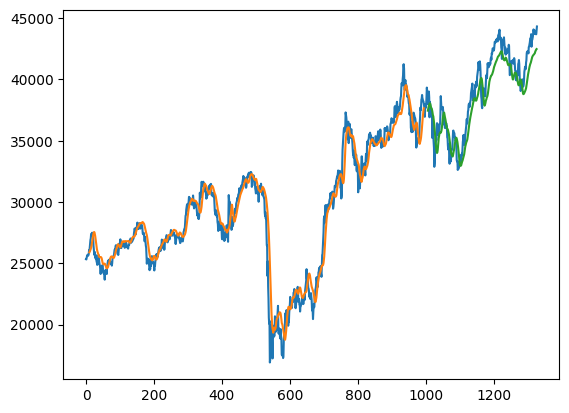

In [60]:
look_back=10
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [61]:
len(test_data)

332

In [62]:
x_input=test_data[len(test_data)-11:].reshape(1,-1)
x_input.shape

(1, 11)

In [63]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [64]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
i=0
x_input = np.array(df1.tolist())
n_steps = 10
while(i<10):
    
    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

# print(lst_output)

0 day input [0.9850992  0.97761593 0.97957259 0.98749747 0.98442031 0.98695176
 0.97685491 0.97698439 0.9892716  1.        ]
0 day output [[0.9323066]]
1 day input [0.97761593 0.97957259 0.98749747 0.98442031 0.98695176 0.97685491
 0.97698439 0.9892716  1.         0.93230659]
1 day output [[0.9318466]]
2 day input [0.97957259 0.98749747 0.98442031 0.98695176 0.97685491 0.97698439
 0.9892716  1.         0.93230659 0.93184662]
2 day output [[0.93094444]]
3 day input [0.98749747 0.98442031 0.98695176 0.97685491 0.97698439 0.9892716
 1.         0.93230659 0.93184662 0.93094444]
3 day output [[0.9285328]]
4 day input [0.98442031 0.98695176 0.97685491 0.97698439 0.9892716  1.
 0.93230659 0.93184662 0.93094444 0.92853278]
4 day output [[0.92419213]]
5 day input [0.98695176 0.97685491 0.97698439 0.9892716  1.         0.93230659
 0.93184662 0.93094444 0.92853278 0.92419213]
5 day output [[0.9190425]]
6 day input [0.97685491 0.97698439 0.9892716  1.         0.93230659 0.93184662
 0.93094444 0.92

In [66]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)

In [67]:
import matplotlib.pyplot as plt

In [68]:
len(df1)

1328

In [69]:
df3=df1.tolist()
df3.extend(lst_output)

In [70]:
df3[-10:]

[[0.9323065876960754],
 [0.9318466186523438],
 [0.9309444427490234],
 [0.9285327792167664],
 [0.9241921305656433],
 [0.9190425276756287],
 [0.9128392338752747],
 [0.906825840473175],
 [0.9002694487571716],
 [0.8923578858375549]]

In [71]:
ds.tail()

,Price
Date,
2023-05-23,43954.449219
2023-05-24,43677.851562
2023-05-25,43681.398438
2023-05-26,44018.000000
2023-05-29,44311.898438


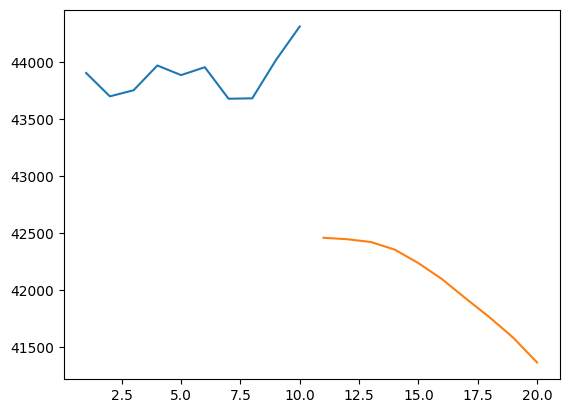

In [72]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-10:])) 
plt.plot(day_pred,scaler.inverse_transform(lst_output))

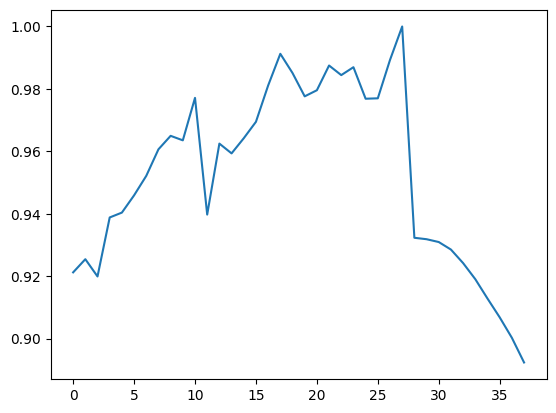

In [73]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1300:])

In [74]:
df3=scaler.inverse_transform(df3).tolist()

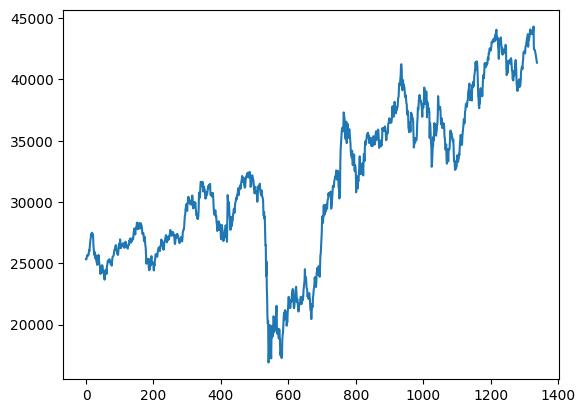

In [75]:
plt.plot(df3)